In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os


current_dir = os.getcwd()
phrase = "QuantitativeFinance"
target_path = current_dir.split(phrase)[0] + phrase
os.chdir(target_path)
print(os.getcwd())

np.set_printoptions(suppress=True)

from functions import eq_option_pricing_binomial_tree, bsm_option_price

%load_ext autoreload
%autoreload 2


c:\OneDrive\Pulpit\QuantitativeFinance


### **Sources**

In [ ]:
# Hull, Options, Futures and Other Derivatives, chapter 13
# The idea is based on Cox, Ross and Rubinstein paper published in 1979

### **Theorem**

In [ ]:
# Let's assume we have one period binomial tree and construct a portfolio consisting of:
# - one call option with underlying X
# - delta shares of X

# We suppose that X price (s0) can:
# - go up (to level s0*u, u > 1 -> % price change = (u - 1)%), let's denote payoff as f_u 
# - go down (to level s0*d, d < 1 -> % price change = (d - 1)%), let's denote payoff as f_d
# - current payoff is denoted as f

# We want out portfolio to be riskless, providing the same value regardless of X price so:
#   s0 * u * delta - f_u = s0 * d * delta - f_d   ->   delta = (f_u - f-d) / (s0 * u - s0 * d)

# Then we do not want to have an arbitrage opportunity so the value of the portfolio must be:
#   (s0 * u * delta - f_u) * e^(-rT)

# While cost of setting this portfolio is:
#   s0 * delta - f

# So the formula for value of the portfolio is:
#   s0 * delta - f = (s0 * u * delta - f_u) * e^(-rT)

# After doing some transformation, we can get final formula:
#   f = e^(-rT) * (p * f_u + (1 - p) * f_d)
# where p = (e^(rT) - d) / (u - d) and can be interpreted as probability of an up movement in 
# risk-neutral world

# Consequently, E(S_T) = p*s0*u + (1-p)*s0*d
# As p = (e^(rT) - d) / (u - d)   ->   E(S_T) = s0*e^(rT) - stock price grows at the risk-free
# rate on average 


In [ ]:
# Generalized version of the model

# f = e^(-r*dt) * (p*f_u + (1-p)*f_d)
# Where p = (e^(r*dt) - d) / (u - d)

# When there are 2 nodes:
# f = e^(-2*r*dt) * (p^2*f_uu + 2*p*(1-p)*f_ud + (1-p)^2*f_dd)
# Where: 
# f_uu - value of an option on the last node when there was up and up move
# f_ud - value of an option on the last node when there was up and down move
# f_dd - value of an option on the last node when there was down and down move

# Parameters u and d have to be matched to volatility of an underlying
# During timestep dt there is probability p that price goes up and (1-p) that goes down
# As we need to match volatility, we can derive from definition of variance (E(X^2) - (E(X))^2),
# as E(X) = p*(u-1) + (1-p)*(d-1), the equation:
# e^(r*dt) * (u+d) - ud - e^(2*r*dt) = sigma^2*dt

# Using series expansion we got:
# u = e^(sigma * sqrt(dt))
# d = e^(-sigma * sqrt(dt))


### Binomial tree price

In [2]:
S = 100
K = 110
T = 1.0
r = 0.1
sigma = 0.3
N = 1024

price, paths = eq_option_pricing_binomial_tree(S, K, T, r, sigma, N)


### Price from Black-Scholes-Merton formula

In [3]:
c, d1, d2 = bsm_option_price(S, K, T, r, sigma, 'call')

# d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))  # TODO: prepare function that calculates it
# d2 = d1 - sigma * np.sqrt(T)
# c = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f'Black-Scholes-Merton analytical option price: {c:.6f}')
print(f'Binomial tree with {N} time steps option price: {price:.6f}')


Black-Scholes-Merton analytical option price: 12.131029
Binomial tree with 1024 time steps option price: 12.129264


### Price from Monte Carlo simulation formula

In [50]:
steps = int(T * 252)  # assumption of 252 trading days per year  # TODO: consider if making bigger dt for weekend is important
path_count = 2 ** 17
prices = np.zeros([250])

dt = T / steps
for j in range(250):
    print(j)
    shocks = np.random.normal(0, 1, (path_count, steps))
    paths_mc = np.zeros((path_count, steps + 1))
    paths_mc[:, 0] = S

    for i in range(1, steps + 1):
        paths_mc[:, i] = paths_mc[:, i - 1] + paths_mc[:, i - 1] * r * dt + sigma * paths_mc[:, i - 1] * np.sqrt(dt) * shocks[:, i - 1]
        
    payoff = np.maximum(paths_mc[:, -1] - K, 0)
    mc_price = payoff.mean() * np.exp(-r*T)
    prices[j] = mc_price
    # print(f'Monte Carlo option price: {mc_price}')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [ ]:
prices.mean(), prices.std()

(np.float64(12.126737751215133), np.float64(0.062052458228433714))

In [54]:
mc_price = prices.mean()

### **Illustration how binomial tree price converges to Black-Scholes-Merton analytical formula by decreasing dt value (perfect convergence when dt -> 0)**

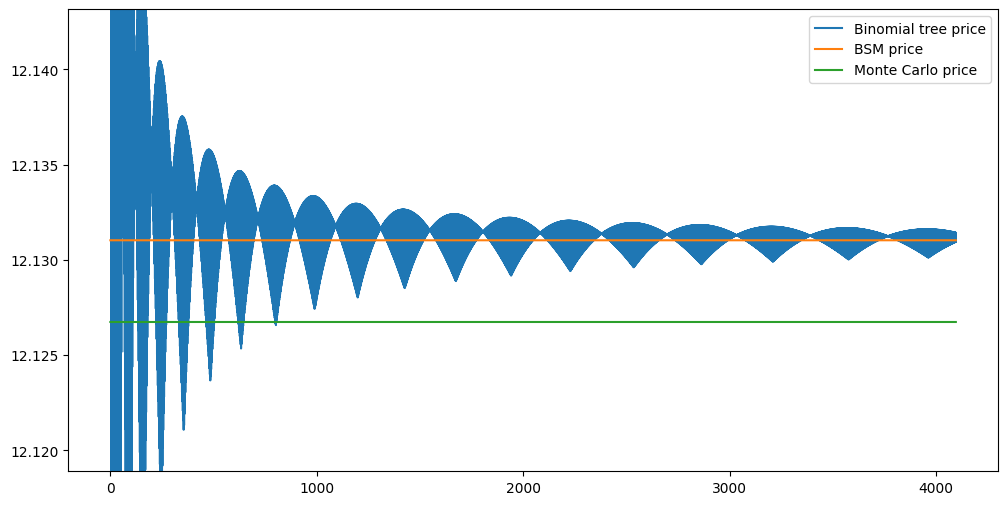

In [55]:
time_steps = 2**12
n_range = np.linspace(1, time_steps, time_steps)  # discretization grid (by how much T is divided)
v_lst = []  # store prices calculated with discretization grid

for n in n_range:
    price, paths = eq_option_pricing_binomial_tree(S, K, T, r, sigma, n)
    v_lst.append(price)

plt.figure(figsize=(12, 6))
plt.plot(n_range, v_lst, label='Binomial tree price')
plt.plot(n_range, np.full_like(v_lst, c), label='BSM price')
plt.plot(n_range, np.full_like(v_lst, mc_price), label='Monte Carlo price')  # too much variance coming from random number sampling
plt.ylim(c * 0.999, c * 1.001)
plt.legend()
plt.show()


In [6]:
# TODO: finish below and add Monte Carlo simulation pricing above

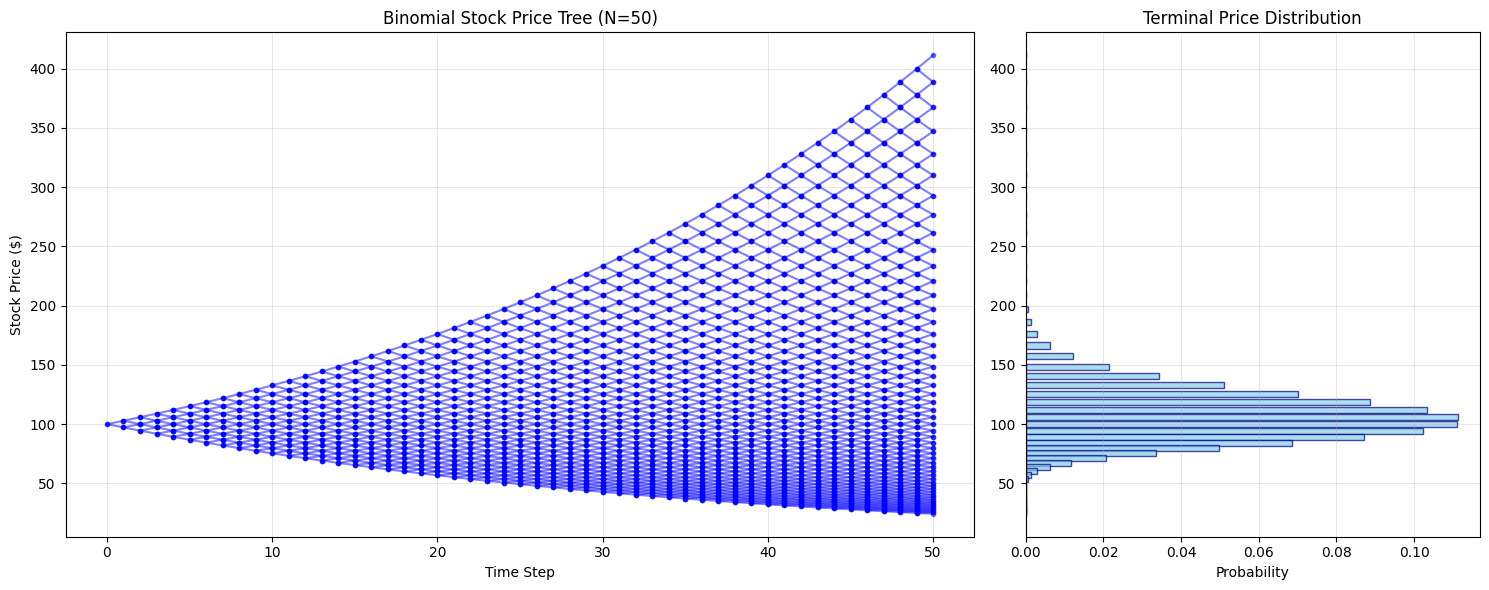

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def plot_binomial_tree_with_dist(S, T, r, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # 1. Generate Tree Data
    tree = []
    for i in range(N + 1):
        # Calculate prices at step i (i+1 nodes)
        prices = S * (u ** np.arange(i, -1, -1)) * (d ** np.arange(0, i + 1, 1))
        tree.append(prices)
    
    # 2. Calculate Terminal Probabilities
    # k is number of up moves. tree[N][0] is k=N, tree[N][N] is k=0
    k_vals = np.arange(N, -1, -1) 
    probs = comb(N, k_vals) * (p**k_vals) * ((1-p)**(N-k_vals))
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Left Plot: The Tree
    for i in range(N):
        for j in range(len(tree[i])):
            # Connect current node to 'up' and 'down' nodes in next step
            ax1.plot([i, i+1], [tree[i][j], tree[i+1][j]], 'b-o', markersize=3, alpha=0.5)
            ax1.plot([i, i+1], [tree[i][j], tree[i+1][j+1]], 'b-o', markersize=3, alpha=0.5)

    ax1.set_title(f"Binomial Stock Price Tree (N={N})")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Stock Price ($)")
    ax1.grid(True, alpha=0.3)

    # Right Plot: The Distribution
    terminal_prices = tree[N]
    ax2.barh(terminal_prices, probs, height=(terminal_prices.max()-terminal_prices.min())/(N*1.5), 
             color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.set_title("Terminal Price Distribution")
    ax2.set_xlabel("Probability")
    ax2.set_ylim(ax1.get_ylim()) # Keep Y-axis aligned with the tree
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example execution
plot_binomial_tree_with_dist(S=100, T=1, r=0.05, sigma=0.2, N=50)